# **Stage 2 - Deep Reinforcement Learning for Infinite Impulse Response (IIR) Filter Implementation - part 1** 

## Scope - *understanding IIR filters and training a DDPG Agent to learn second order IIR filters suitable for a constant interference situation*
References:- Chapter 11 of *Digital Signal Processing: signals, systems, and filters* by *Andreas Antoniou*, SciPy `signal` documentation

### Introduction to IIR Fitering
- A general IIR filter can be given by the *difference equation* 

$$ 
    \sum_{i=0}^{N} a_i y[n-i] = \sum_{j=0}^{M} b_j x[n-j]
$$
, where $a_i \neq 0$ for at least one $i \in (0, N]$, which indicates that the current output $y[n]$ depends on the previous outputs of the same system $y[n-i]$, $i \in (0, N]$, thus resulting in a *recursive* (IIR) filter. 
- Typically, for normalization, the coefficient $a_0$ is taken as 1, thus the differece equation can be rewritten as an expression for the current output as 
$$
    y[n] = b_0 x[n] + b_1 x[n-1] + b_2 x[n-2] + \cdots + b_M x[n-M] - a_1 y[n-1] - a_2 y[n-2] - \cdots - a_N y[n-N]
$$. 
- The above equation clearly depicts the fact that, to estimate the initial output of the system $y[0]$, one must specify the values of the system output for $N$ consecutive time-steps into the past along with the current input and the inputs of the system for past $M$ consecutive time steps, which are collectively known as *initial conditions*. 
- Moreover, in the following discussion, we will always assume $M = N$ (i.e., the numerator and denominator polynomials of an IIR filter transfer function (TF) always have the same order) to make the filter implementations simpler. This condition will also guarantee that the filter is going to be *causal* and furthermore *practically realizable* if stability condition is also satisfied (see reference book). 

### IIR Filter Implementation in Python SciPy
- Here, we will use the same choice for the state as in the previous FIR filter implementation (stage 1); the state is a sequence of audio samples of length $S$. 
- In the DRL implementation, as the actor moves from one state to another state, it predicts a different action (a different IIR filter), and we have to pass down initial conditions from state to state to estimate the filter output sequentially. 
- To implement an IIR filter in Python, we can use `scipy.signal.lfilter` function. As explained in `scipy.signal` documentation, the operation of this function requires the initial conditions to be fed as a 1-D array `zi`, which represents an array of intermediate results in the implementation; when the initial conditions are provided, the values of those intermediate results at the end of the current input sequence are also returned to be used as the initial conditions for the next input sequence. 
- At the start of the audio signal (i.e., for the very first state), the initial conditions `zi` must be specified as an array of zeros of appropriate size since $x[-j]$ for $1 \leq j \leq M$ are all zero (because there are no audio samples before the start of the signal) and $y[-i]$ for $1 \leq i \leq N$ are also zero, assuming *initial rest*  (see the documentation to understand how the `zi` array is calculated given the initial input and output values of the system). Alternatively, one can use `scipy.signal.lfiltic` function to produce `zi` from initial input (`x`) and output (`y`) values... 

In [75]:
import os, sys, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import lfilter, iirdesign, zpk2tf, freqz

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.losses import MSE

import gymnasium as gym 
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env

sys.path.append('../')
from stage1_helper import create_target_and_jammed_signals, Spectrum, SNR, power

In [60]:
# let's use vignesh.wav
SAMPLING_FREQ = 44_100 #Hz
TRUNCATION_FREQ = 5_000 #Hz
INTERFERENCE_CENTER_FREQ = 15_000 #Hz
S = 100 # signal partition size

target, jammed = create_target_and_jammed_signals(
    audio_name = 'vignesh',
    truncation_freq = TRUNCATION_FREQ,
    interference_center_freq = INTERFERENCE_CENTER_FREQ, 
    signal_partition_size = S
)

audio name: 'vignesh'
sampling rate: 44100 Hz
audio shape: (136477,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -13841.346435316103 (>=-32768) to max: 14399.410754652867 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 0 and upper -1 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -38983.15088455426 (>=-2147483648) to max: 41992.824003714835 (<=2147483647)


In [14]:
# now, declare an IIR filter to remove the interference
b, a = iirdesign(
    wp = TRUNCATION_FREQ, # pass band frequency
    ws = INTERFERENCE_CENTER_FREQ - TRUNCATION_FREQ, # stop band frequency
    gpass = 5, # maximum loss in pass band gain (dB)
    gstop = 20, # minimum stop band attenuation (dB)
    fs = SAMPLING_FREQ, # sampling freq
    output = 'ba'
)
print(f'numerator coefficients  : {b} \ndenominator coefficients: {a}')

numerator coefficients  : [ 0.12323154 -0.07412943  0.12323154] 
denominator coefficients: [ 1.         -1.44973382  0.75619119]


In [31]:
# applying the filter over 10 states as a whole...
# - let's take 1000 (=10 x S) long sequence from the audio
ref_jammed = jammed[:S*10]
ref_filtered, ref_initial_cond = lfilter(
    b = b, # numerator polynomial coefficients
    a = a, # denominator polynomial coefficients
    x = ref_jammed,  # input
    zi = np.zeros(2) # initial conditions
)
print(len(ref_filtered))
print(ref_initial_cond)

1000
[ 5.75489706 -2.02060852]


In [32]:
# applying the filter over 10 states sequentially passing down initial conditions at each step
filtered_output = np.zeros((S*10, ))
initial_cond = np.zeros(2)

for step in range(10):
    jammed_partition = jammed[S*step : S*(step+1)]
    filtered_partition, initial_cond = lfilter(
        b = b,
        a = a,
        x = jammed_partition,
        zi = initial_cond, 
    )
    filtered_output[S*step : S*(step+1)] = filtered_partition

In [33]:
# the final filtered audio signal must be same in both cases... 
np.all(filtered_output == ref_filtered)

True

## **Audio Signal Receiver Environment with IIR Filtering**

### Choice of Actions

- To define an environment suitable for learning IIR filters, we first have to agree on a choice for *action*. 
- Let's consider **second order IIR filers** (i.e., both the numeartor and denominator polynomials of the transfer function of the IIR filter are of second order).
- In that case, a general transfer function would be in the following format. 
$$
    H(\omega) = \frac{N(\omega)}{D(\omega)} = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}
$$

#### Choice 1 - *Chossing Transfer Function Coefficients*
- So, one choice for actions can be taken as chossing the above 5 coefficients, $b_0$, $b_1$, $b_2$, $a_1$, and $a_2$. 
- But this choice of action suffers 2 main problems;
> - there is no boundary for the action (i.e., there is no known limit for the value of each coefficient); this is a problem because DDPG algorithm typically suggests to normalize the action space into the range $[0, 1]$ or $[-1, 1]$. 
> - there is no guarantee that a particular choice of coefficient will result in a **stable** IIR filter. 

#### Choice 2 - *Choosing Zeros, Poles, and Gain*
- One can rewrite the above transfer function of a generic second-order IIR filter  $H(\omega)$ in terms of its zeros and poles, as in,  
$$
    H(\omega) = \frac{k (z - z_1)(z - z_2)}{(z - p_1)(z - p_2)}
$$
, where $k$ is a fixed gain, $z_1$ and $z_2$ are *complex conjugate zeros*, and $p_1$ and $p_2$ are the *complex conjugate poles* of the filter. 
- Therefore, one convenient choice of action is choosing the fixed gain, one zero and one pole since when a zero and a pole are declared, the remaining zero-pole pair is directly given by their complex conjugates.  
- We can also easily ensure the stability of an IIR filter in this way if the poles are constrained to always lie within the unit circle $\vert z \vert = 1$. 
- Now, to inact the above constraint for the poles, it is convenient to express poles and zeros in the polar form, $r e^{j\theta}$, where $r$ is the magnitude (radius) of the complex number and $\theta$ is the angle respective to the positive direction of x-axis (phase). Then, limiting $r$ of a pole to be strictly less than $1$ would guarantee the stability. 
- This way, the choice of IIR filter can be defined in terms of 5-dimensional action space; 
> - $r_{z}$ - magnitude of the zeros
> - $\theta_{z}$ - phase of the zero on the positive semi circle ($0 \leq \theta_{z1} \leq \pi$)
> - $r_{p}$ - magnitude of the poles
> - $\theta_{p}$ - phase of the pole on the positive semi circle ($0 \leq \theta_{p1} \leq \pi$), and
> - $k$ - constant gain. 
- As discussed above, choice of $r_p$ can be directly normalized to the range $[0, 1]$, and since the values of both $\theta_z$ and $\theta_p$ are always within the range $[0, \pi]$, their values also can be normalized to $[0, 1]$ and later scaled-up to the original range before constructing the filter. 
- However, there is no need to constrain the choice of $r_z$ to be within $[0, 1]$. But if you think of a second order low-pass filter for removing non-overlapping interference, such a filter can be easily implemented by placing the zeros on the unit circle, so $r_z = 1$ (remember, zeros define the stop band of a filter) (see the section 5.6.2. of the reference book). Therefore, putting an artificial constraint on $r_z$ to be within $[0, 1]$ must do no harm... 
- Let's also limit the fixed gain $k$ to be within the same normalized range $[0, 1]$ *which is a justifiable choice*... 
- With the above constraints on each action, the actor network in DDPG agent can be implemented with a trailing dense layer of 5 units with `sigmoid` activation. 

### Declaring the Environment

- Since the action has been declared, now we can define the environment for IIR filters. 

In [61]:
# define custom functions
def polar2cmplx(r, theta):
    """
    Creates a complex number when radius and angle given in polar form.
    :param r: absolute value/modulus/magnitude of the complex number
    :param theta: argument/angle of the complex number

    Returns the corresponding complex number (in the format a+bj). 
    """
    return r * np.exp((0+1j) * theta)

In [92]:
# receiver environment with IIR filtering
class ReceiverEnvWithSecondOrderIIR(gym.Env):
    """
    A custom environment developed in the accordance with gym environment API that immitates a receiver of jammed audio with IIR filtering. 
    :param S: signal partition size which represents a state 
    :param cut_off_freq: the frequency to truncate the audio spectrum to generate the target signal; equivalent to the ideal cut-off frequency of the learned filter
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference
    :param audio_json: path of a json file containing the names of the audio wav files the environment can access\
        put the audio file names without the .wav extension in a json array inside the file
    """

    # define constants 
    MIN_BUFFER_SIZE = 10 # RAISE THIS LATER!!!
    EPISODE_LENGTH  = np.inf # np.inf
    MAX_TOTAL_NUM_OF_STEPS = np.inf

    def __init__(self, S:int, cut_off_freq:int, interference_center_freq:int, audio_json:str = '/home/akila/FYP/coding/stage_1/audio_files/audio_files.json'):

        super(ReceiverEnvWithSecondOrderIIR, self).__init__()

        # ----- verifying input arguments and setting them as class atributes ----
        # signal partition size
        if S < self.MIN_BUFFER_SIZE:
            raise Exception(f"the buffer size 'S' must be larger than MIN_BUFFER_SIZE, {self.MIN_BUFFER_SIZE}: given {S}")
        self.S = S

        # other parameters
        self.cut_off_freq = cut_off_freq
        self.interference_center_freq = interference_center_freq
        self.audio_json = audio_json

        # ----------------------------- Action Space -----------------------------
        # action - choosing fixed gain k, zeros, and poles of an N-th order IIR filter
        # note that the action is NOT TUNING/,ADJUSTING, or CHANGING the coefficeints of an existing filter. 
        action_shape = (5, )
        self.action_space = spaces.Box(low=0, high=1, shape=action_shape, dtype=np.float32) # float16 -> float32, lower limit must be 0. 

        # ----------------------------- State Space ------------------------------
        state_shape = (self.S, )
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=state_shape, dtype=np.int32)

        # ------------------------- other class attributes ------------------------
        self.global_counter = 0  # a counter to keep track of the number of elapsed time steps of the environment
        self.counter = 0         # a counter to keep track of the number of elapsed time steps in the current episode
        self.episode_counter = 0 # a counter to keep track of the number of total episodes

    def reset(self, seed=None, options=None):

        super().reset(seed=seed, options=None) # options must be forced to None

        # set show_effect option
        self.show_effect = True
        if isinstance(options, dict) and 'show_effect' in options:
            self.show_effect = options['show_effect']
        
        # reset the counters
        if isinstance(options, dict) and 'reset_all' in options and options['reset_all'] == True:
            self.global_counter  = 0
            self.episode_counter = 0
        self.counter = 0
        self.episode_counter += 1

        print('\n' + "-" * 50 + f"episode no: {self.episode_counter}" + "-" * 50)

        # for each episode, choose the audio signal specified by `audio_num` in the options
        with open(self.audio_json) as audio_json_file:
            train_audio_names = json.load(audio_json_file)["train"]
        audio_num = 0 # default audio track - 'vignesh.wav'
        if isinstance(options, dict) and 'audio_num' in options:
            audio_num = options['audio_num']
        
        # i = np.random.randint(low=1, high=self.audio_num) # len(train_audio_names)
        # create the target and jammed signals
        target_signal, jammed_signal = create_target_and_jammed_signals(train_audio_names[audio_num], self.cut_off_freq, self.interference_center_freq, self.S)
        self.target_signal = target_signal
        self.jammed_signal = jammed_signal
        print()

        # return the initial state 
        self.state = jammed_signal[:self.S]

        # declare the initial conditions in the start of the audio
        self.initial_conds = np.zeros(2)

        info = {}

        # return the initial state and info
        return self.state, info

    def step(self, action):

        # increment the counters
        self.global_counter += 1
        self.counter += 1

        # ----- create the filter -----
        # extract the zero, pole, and gain, and find the transfer function of the filter
        z = polar2cmplx(action[0], np.pi * action[1])
        p = polar2cmplx(action[2], np.pi * action[3])
        k = action[4]

        zs = (z, np.conjugate(z)) # array of zeros of TF
        ps = (p, np.conjugate(p)) # array of poles of TF

        b, a = zpk2tf(zs, ps, k)

        # get signal partition from the buffer
        partition = self.state

        # generating the next state
        terminated = False
        if self.S * (self.counter + 1) >= len(self.jammed_signal):
            terminated = True
        else:
            self.state = self.jammed_signal[self.S * self.counter : self.S * (self.counter + 1)]
        
        # apply the IIR filter to the current state and set the initial conditions for the next state
        filtered, self.initial_conds = lfilter(b, a, partition, zi=self.initial_conds)
        target = self.target_signal[self.S * (self.counter - 1) : self.S * self.counter]

        # calculate the reward (SNR)
        reward = SNR(target, filtered)
        if np.isnan(reward):
            print(f"reward value is not a number... \nfilter: {filter}; assigning -20dB as the reward...")
            reward = -20 # assign a very large negative reward
            # raise Exception(f"reward value is not a number...\ntarget: {target}\nfiltered: {filtered}\nfilter: {filter}")
        
        # if self.counter % 50 == 1:
        if self.show_effect: print(f"step: {self.counter}, SNR: {reward}, filter: {b}, {a}")
        
        # truncating the episode
        truncated = False
        if self.episode_counter == self.EPISODE_LENGTH or self.global_counter == self.MAX_TOTAL_NUM_OF_STEPS:
            truncated = True
        
        info = {} 

        return self.state, reward, terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

In [ ]:
# check the environment
env_for_test = ReceiverEnvWithSecondOrderIIR(
    S = 100,
    cut_off_freq = TRUNCATION_FREQ,
    interference_center_freq = INTERFERENCE_CENTER_FREQ
)
check_env(env_for_test)
# env checking is successful unless for a warning saying "UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1])"...

### Launching a custom DDPG agent

In [63]:
# =============================== REPLAY BUFFER ===============================
class ReplayBuffer:
    def __init__(self, max_size, state_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory     = np.zeros((self.mem_size, *state_shape))
        self.action_memory    = np.zeros((self.mem_size, n_actions))
        self.reward_memory    = np.zeros(self.mem_size)
        self.new_state_memory = np.zeros((self.mem_size, *state_shape))
        self.terminal_memory  = np.zeros(self.mem_size, dtype=np.bool_) # using np.bool is really useful when pytorch is used.

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size # implement a queue

        self.state_memory[index]     = state
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.new_state_memory[index] = new_state
        self.terminal_memory[index]  = done # problematic !!!

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace=False) # replace = False -> in a single batch, no element gets sampled more than once. 

        states     = self.state_memory[batch]
        actions    = self.action_memory[batch]
        rewards    = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones      = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones



# =============================== CRITIC NETWORK ===============================
class CriticNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(CriticNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 
        # extensions for saving keras models: legacy '.h5' -> TF 1.X, '.tf' -> TF 2.X

        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # # define network layers 
        # self.fc1 = Dense(self.fc1_dims, activation='relu')
        # self.fc2 = Dense(self.fc2_dims, activation='relu')
        # self.q   = Dense(1, activation=None)

        # # define network layers 
        # self.hidden1  = Dense(self.fc1_dims, activation='relu', name="critic_hidden1")
        # self.hidden2  = Dense(self.fc2_dims, activation='relu', name="critic_hidden2")
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # self.hidden2_ = Dense(self.fc2_dims, activation='relu', name="critic_hidden2_")
        # self.q        = Dense(1, activation=None, name="q_value") # change the activation appropriately

        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)

        # define network layers
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims,
            activation='relu',
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name="critic_hidden1"
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2"
        )
        self.action_normalizer  = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2_ = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name="critic_hidden2_"
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.q = Dense(
            units=1,
            activation=None, # None
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name="q_value"
        )

    def call(self, state, action):
        # # temp1 = self.fc1(tf.concat([state, action], axis=1)) # axis 0 -> batch dimension
        # temp1 = self.fc1(action)
        # # ######################## PROBLEM ########################
        # # according to the paper, actions were not included until the 2nd hidden layer of Q
        # temp2 = self.fc2(temp1)
        # q_value = self.q(temp2)

        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_action  = self.action_normalizer(action) # may not be required since action is already bounded between [-1, +1], but they may be too small compared to normalized_hidden1 activations
        # hidden2_           = self.hidden2_(normalized_action)
        hidden2_           = self.hidden2_(action)
        normalized_hidden2 = self.hidden2_normalizer(tf.concat([hidden2, hidden2_], axis=1)) ######
        q_value            = self.q(normalized_hidden2)
        # q_value = self.q(tf.concat([hidden2, hidden2_], axis=1))

        return q_value

# ================================ ACTOR NETWORK ===============================
class ActorNetwork(keras.Model):
    def __init__(
            self,
            name, # model name (required by tf.keras.Model)
            n_actions, # action shape (dimenisonality of action space)
            fc1_dims,
            fc2_dims,
            chkpt_dir='tmp/ddpg/'
    ):
        super(ActorNetwork, self).__init__()

        self.model_name = name # do not use 'self.model'; it is a reserved variable name in tf
        self.checkpoint_dir  = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5') 

        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        # weight and bias initialziers
        hidden1_initializer = RandomUniform(minval=-1/np.sqrt(self.fc1_dims), maxval=1/np.sqrt(self.fc1_dims))
        hidden2_initializer = RandomUniform(minval=-1/np.sqrt(self.fc2_dims), maxval=1/np.sqrt(self.fc2_dims))
        final_layer_initializer = RandomUniform(minval=-3*10**-4, maxval=3*10**-4)
        
        # define network layers including layer noramlizations
        self.state_normalizer   = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden1 = Dense(
            units=self.fc1_dims, 
            activation='relu', 
            kernel_initializer=hidden1_initializer,
            bias_initializer=hidden1_initializer,
            name='actor_hidden1'
        )
        self.hidden1_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.hidden2 = Dense(
            units=self.fc2_dims, 
            activation='relu', 
            kernel_initializer=hidden2_initializer,
            bias_initializer=hidden2_initializer,
            name='actor_hidden2'
        )
        self.hidden2_normalizer = LayerNormalization(epsilon=10**-4, center=False, scale=False)
        self.mu = Dense(
            units=n_actions,
            activation='sigmoid', # limit the action in the range [0, 1] -> 'sigmoid'
            kernel_initializer=final_layer_initializer,
            bias_initializer=final_layer_initializer,
            name='action'
        )

    def call(self, state):
        normalized_state   = self.state_normalizer(state)
        hidden1            = self.hidden1(normalized_state)
        # normalized_hidden1 = self.hidden1_normalizer(hidden1)
        # hidden2            = self.hidden2(normalized_hidden1)
        hidden2            = self.hidden2(hidden1)
        # normalized_hidden2 = self.hidden2_normalizer(hidden2)
        # action             = self.mu(normalized_hidden2)
        action             = self.mu(hidden2)

        return action



# ================================== DDPG AGENT =================================
class DDPGAgent:
    def __init__(
            self,
            input_dims, # state shape
            n_actions,  # dimensionality of actions
            # env,        # gymnasium env
            alpha,      # learning rate of actor
            beta,       # learning rate of critic
            gamma,      # discounting factor
            tau,        # soft target update factor
            critic_fc1,
            critic_fc2,
            actor_fc1,
            actor_fc2,
            batch_size,
            buffer_size,
            noise
    ):
        # set the class attributes
        self.tau = tau
        self.n_actions = n_actions
        self.noise = noise
        self.batch_size = batch_size
        self.gamma = gamma

        # instantiate replay buffer
        self.memory = ReplayBuffer(buffer_size, state_shape=input_dims, n_actions=n_actions)

        # instantiate the networks
        self.actor  = ActorNetwork(name="actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.critic = CriticNetwork(name="critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)
        self.target_actor  = ActorNetwork(name="target_actor", n_actions=n_actions, fc1_dims=actor_fc1, fc2_dims=actor_fc2)
        self.target_critic = CriticNetwork(name="target_critic", fc1_dims=critic_fc1, fc2_dims=critic_fc2)

        # compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        # target networks do not require an optimizer or a learning rate since they are learned through soft updates.
        # but, to use the networks in TF2, we have to compile them with an optimizer and a learning rate. 
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # load identical weights to target networks
        self.update_target_network_parameters(tau=1)

    def update_target_network_parameters(self, tau=None):
        if tau == None:
            tau = self.tau

        target_actor_weights = self.target_actor.weights
        for i, actor_weights in enumerate(self.actor.weights):
            target_actor_weights[i] = tau * actor_weights + (1-tau) * target_actor_weights[i]
        self.target_actor.set_weights(target_actor_weights)

        target_critic_weights = self.target_critic.weights
        for i, critic_weights in enumerate(self.critic.weights):
            target_critic_weights[i] = tau * critic_weights + (1-tau) * target_critic_weights[i]
        self.target_critic.set_weights(target_critic_weights)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... saving models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.save_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.save_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.save_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.save_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def load_models(self, checkpoint_file_name, checkpoint_dir):
        print("..... loading models .....")
        if not os.path.exists(checkpoint_dir):
            raise Exception(f"the provided checkpoint directory doesn't exist: given '{checkpoint_dir}'")
        self.actor.load_weights(checkpoint_dir + checkpoint_file_name + '_actor_ddpg.h5')
        self.critic.load_weights(checkpoint_dir + checkpoint_file_name + '_critic_ddpg.h5')
        self.target_actor.load_weights(checkpoint_dir + checkpoint_file_name + '_target_actor_ddpg.h5')
        self.target_critic.load_weights(checkpoint_dir + checkpoint_file_name + '_target_critic_ddpg.h5')

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32) # introducing the batch dimension
        action = self.actor(state) # 'action' would also have a batch dimension 

        if not evaluate:
            # while training the agent, introduce an exploration noise
            # here, the exploration noise is sampled from a normal distribution with zero mean and specified std deviation. 
            action += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=self.noise)
            # when added the noise, the action can go beyond the action space limits; so, clip the actions.
            action = tf.clip_by_value(action, clip_value_max=1.0, clip_value_min=-1.0)

        return action[0] # get rid of the batch dimension
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states     = tf.convert_to_tensor(state, dtype=tf.float32)
        actions    = tf.convert_to_tensor(action, dtype=tf.float32)
        rewards    = tf.convert_to_tensor(reward, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_state, dtype=tf.float32)

        # update the critic
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(new_states)
            next_step_critic_values = tf.squeeze(self.target_critic(new_states, target_actions), axis=1)
            critic_values = tf.squeeze(self.critic(states, actions), axis=1)
            targets = rewards + self.gamma * next_step_critic_values * (1-done) # y_i
            critic_loss = MSE(targets, critic_values)
        
        critic_network_gradients = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(critic_network_gradients, self.critic.trainable_variables))

        # update the actor
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            critic_values_ = -self.critic(states, new_policy_actions) # why (-) ? gradient ascent
            actor_loss = tf.math.reduce_mean(critic_values_)

        actor_network_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradients, self.actor.trainable_variables))

        # soft target updates
        self.update_target_network_parameters()

### Training the DDPG Agent

In [88]:
# define train and test functions
def train(model_, env_, audio_num, max_num_steps, show_effect=True, reward_history=None, action_history=None):
    """
    Trains a model in a given environment over a specified number of time steps.
    :param model_: the DRL model 
    :param env_: the environment the model is going to trained in
    :param audio_num: the number/index of the audio track to be used as the training data
    :param max_num_steps: the maximum number of time steps for training

    Returns None
    """

    if reward_history == None: reward_history = [][:]
    if action_history == None: action_history = []
    step_count = 0

    # reset the environment
    state, _ = env_.reset(options={'reset_all': True, 'audio_num':audio_num, 'show_effect': show_effect}) # FOR SINGLE EPISODE
    done = False

    while not done:
        # feed the state to the agent (model) and get an action
        action = model_.choose_action(state).numpy() # this includes the exploration noise

        # take the action in the environment
        next_state, reward, terminated, truncated, _ = env_.step(action)
        done = terminated | truncated
        step_count += 1

        # store the transition in the replay buffer of the DDPG agent
        model_.remember(state, action, reward, next_state, done)

        # train the model
        model_.learn()

        # set the `next_state` as `state`
        state = next_state

        # keep track of `reward` and `action`
        reward_history.append(reward)
        action_history.append(action)
        
        if step_count >= max_num_steps:
            done = True

    return reward_history, action_history

In [48]:
# declare the environment
env = ReceiverEnvWithSecondOrderIIR(S, cut_off_freq=TRUNCATION_FREQ, interference_center_freq=INTERFERENCE_CENTER_FREQ)

# launch a DDPG agent
keras.backend.clear_session()
model = DDPGAgent(
    input_dims  = env.observation_space.shape,
    n_actions   = env.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 512,
    critic_fc2  = 256, #...
    actor_fc1   = 256,
    actor_fc2   = 128,
    batch_size  = 128,
    buffer_size = 2000,
    noise       = 0.01
)

# train the model
train_time_steps = 128*20
reward_history, action_history = train(model, env, audio_num=1, max_num_steps=train_time_steps)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49140.51895186492 (>=-2147483648) to max: 49149.0 (<=2147483647)

step: 1, SNR: 1.412547554546337, filter: [ 0.50396585 -0.021619    0.12388195], [1.         0.03361572 0.25420452]
step: 2, SNR: 1.6132005186613132, filter: [0.50417668 0.0123891  0.1365796 ], [1.    

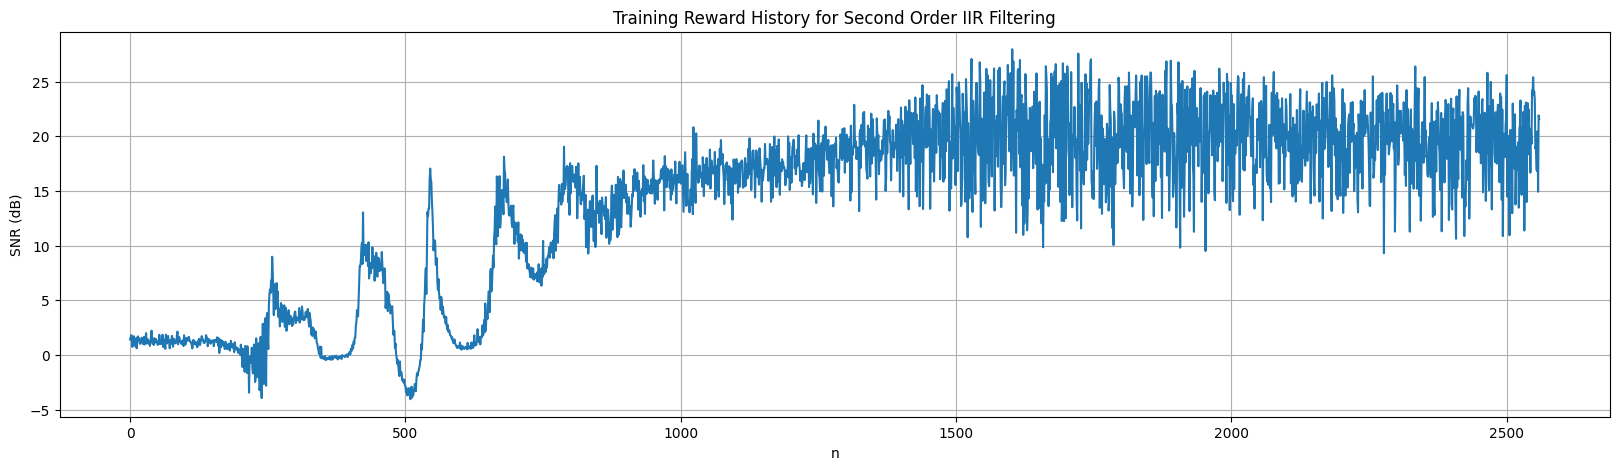

In [49]:
# plotting the results
plt.figure(figsize=(20, 5))
plt.plot(reward_history)
plt.title("Training Reward History for Second Order IIR Filtering")
plt.xlabel("n")
plt.ylabel("SNR (dB)")
plt.grid(True)

### Training the Model longer...

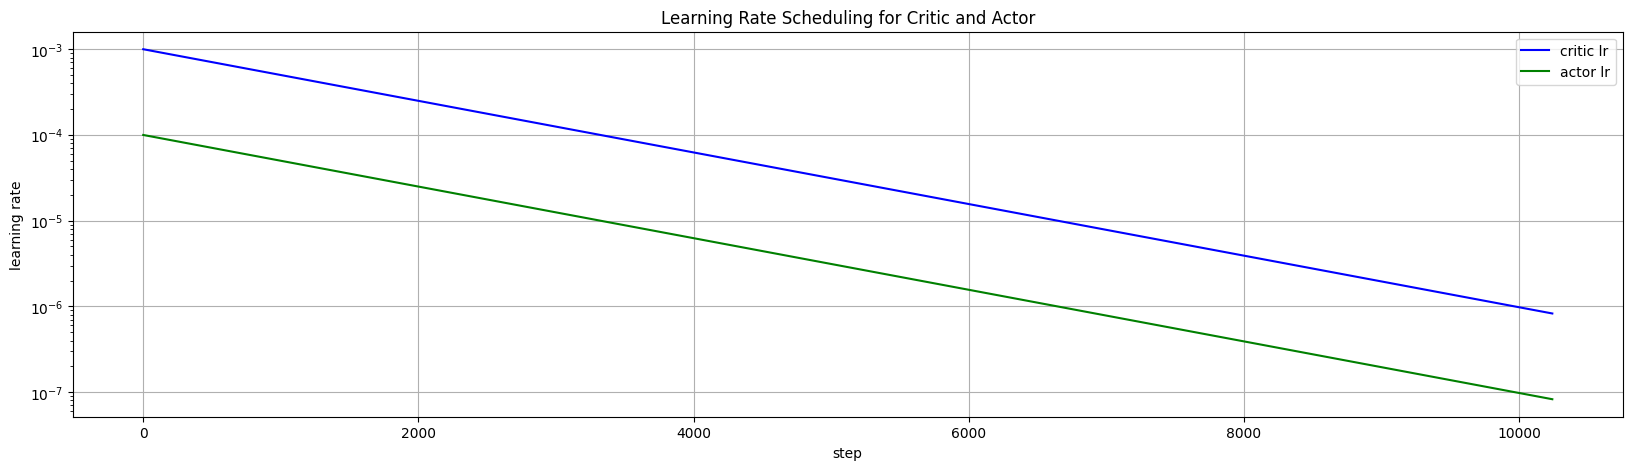

In [211]:
# learning rate scheduler
initial_critic_learning_rate = 0.001
critic_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_critic_learning_rate,
    decay_steps=1000,
    decay_rate=0.50,
    staircase=False
)

initial_actor_learning_rate = 1e-4
actor_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_actor_learning_rate,
    decay_steps=1000,
    decay_rate=0.50,
    staircase=False
)

# DEFINE `train_time_steps` HERE...
train_time_steps = 128 * 80

step = 1
critic_lr_history = []
actor_lr_history = [][:]
for _ in range(train_time_steps):
    critic_lr_history.append(critic_lr_schedule(step))
    actor_lr_history.append(actor_lr_schedule(step))
    step += 1

plt.figure(figsize=(20, 5))
plt.semilogy(range(1, train_time_steps+1), critic_lr_history, 'b', label='critic lr')
plt.semilogy(range(1, train_time_steps+1), actor_lr_history,  'g', label='actor lr')
plt.title("Learning Rate Scheduling for Critic and Actor")
plt.xlabel("step")
plt.ylabel("learning rate")
plt.legend()
plt.grid(True)

In [80]:
# launch a new DDPG agent
keras.backend.clear_session()
model_1 = DDPGAgent(
    input_dims  = env.observation_space.shape,
    n_actions   = env.action_space.shape[0],
    alpha       = 0.0001, # learning rate of actor
    beta        = 0.001,  # learning rate of critic
    gamma       = 0.1,
    tau         = 0.001,
    critic_fc1  = 512,
    critic_fc2  = 256, #...
    actor_fc1   = 256,
    actor_fc2   = 128,
    batch_size  = 128*2,
    buffer_size = 128*2, # buffer size is reduced to the batch size
    noise       = 0.01
)

# train the model
train_time_steps = 128*40
reward_history_1, action_history_1 = train(model_1, env, audio_num=4, max_num_steps=train_time_steps)
reward_history_1, action_history_1 = train(model_1, env, audio_num=1, max_num_steps=train_time_steps, reward_history=reward_history_1, action_history=action_history_1)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'rain_on_me-MONO'
sampling rate: 44100 Hz
audio shape: (8305664,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -18879.494656565814 (>=-32768) to max: 17182.003427808108 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 23603 and upper -250474 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49095.53950461225 (>=-2147483648) to max: 49100.5372207998 (<=2147483647)

step: 1, SNR: 2.0106051563684164, filter: [ 0.49365625 -0.03458489  0.11783617], [ 1.         -0.04220288  0.28261934]
step: 2, SNR: 2.038228572455644, filter: [ 0.46465918 -0.00747604  0.1180106

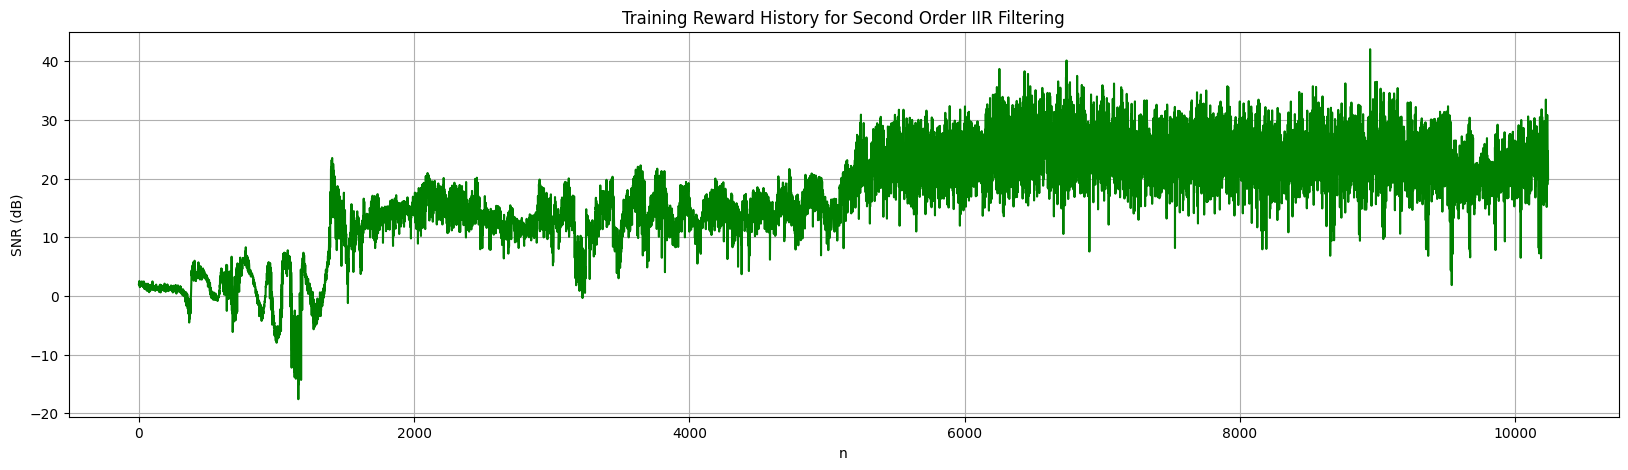

In [81]:
# # print the final learning rate for confirmation of LR scheduling
# print(f"final critic learning rate: {model.critic.optimizer.learning_rate.numpy()}")
# print(f"final actor learning rate : {model.actor.optimizer.learning_rate.numpy()}")

# plotting the results
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(reward_history_1)+1), reward_history_1, 'g')
plt.title("Training Reward History for Second Order IIR Filtering")
plt.xlabel("n")
plt.ylabel("SNR (dB)")
plt.grid(True)

### Testing the DDPG Agent

In [82]:
def test(model_, env_, audio_num, num_steps, show_effect=False):
    """
    Tests a model in a given environment with the specified number of time steps and with provided testing data.
    :param model_: the trained DRL model to be tested 
    :param env_: the environment the model is going to tested in
    :param audio_num: the number/index of the audio track to be used as the testing data
    :param num_steps: the number of time steps for testing

    Returns the rewards and the actions taken
    """

    reward_history = []
    action_history = []
    step_count = 0

    # reset the environment
    state, _ = env_.reset(options={'reset_all': True, 'audio_num':audio_num, 'show_effect': show_effect}) # FOR SINGLE EPISODE
    done = False

    while not done:
        # feed the state to the agent (model) and get an action
        action = model_.choose_action(state, evaluate=True).numpy() # this DOES NOT include the exploration noise

        # take the action in the environment
        next_state, reward, terminated, truncated, _ = env_.step(action)
        done = terminated | truncated
        step_count += 1

        # set the `next_state` as `state`
        state = next_state

        # keep track of the `reward` and `action`
        reward_history.append(reward)
        action_history.append(action)
        
        if step_count >= num_steps:
            done = True

    return reward_history, action_history


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'august-MONO'
sampling rate: 44100 Hz
audio shape: (11636736,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -16963.15372482877 (>=-32768) to max: 17187.659731769407 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 27620 and upper -124323 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -48432.0 (>=-2147483648) to max: 48732.237134547875 (<=2147483647)

step: 1, SNR: 19.183299535486803, filter: [0.15619007 0.23374087 0.15616581], [ 1.         -0.90073626  0.46446949]
step: 2, SNR: 25.563025007672874, filter: [0.15744653 0.2345875  0.15742078], [ 1.         

/home/akila/FYP/coding/stage_2/../stage1_helper.py:282: RuntimeWarning: divide by zero encountered in scalar divide


step: 41, SNR: 21.415804079275173, filter: [0.1542975  0.23244961 0.15427628], [ 1.         -0.90869355  0.46881713]
step: 42, SNR: 23.903167684708407, filter: [0.15495817 0.23241854 0.15493636], [ 1.         -0.91055274  0.46937004]
step: 43, SNR: 24.245186658770486, filter: [0.15595108 0.23310474 0.15592731], [ 1.         -0.90741084  0.47003434]
step: 44, SNR: 24.215090094873304, filter: [0.15824799 0.23575872 0.15822234], [ 1.         -0.89297532  0.46172728]
step: 45, SNR: 25.01935187348973, filter: [0.15667419 0.23332781 0.1566492 ], [ 1.         -0.90458809  0.46857049]
step: 46, SNR: 21.88820356166145, filter: [0.15592612 0.23364465 0.15590298], [ 1.         -0.90305623  0.46640005]
step: 47, SNR: 21.20103661011655, filter: [0.15863739 0.23554935 0.15861048], [ 1.         -0.89598555  0.46673585]
step: 48, SNR: 21.346020532876793, filter: [0.16437952 0.24074011 0.16434513], [ 1.         -0.87187451  0.45803623]
step: 49, SNR: 23.49334675238536, filter: [0.15717514 0.23378979 0.

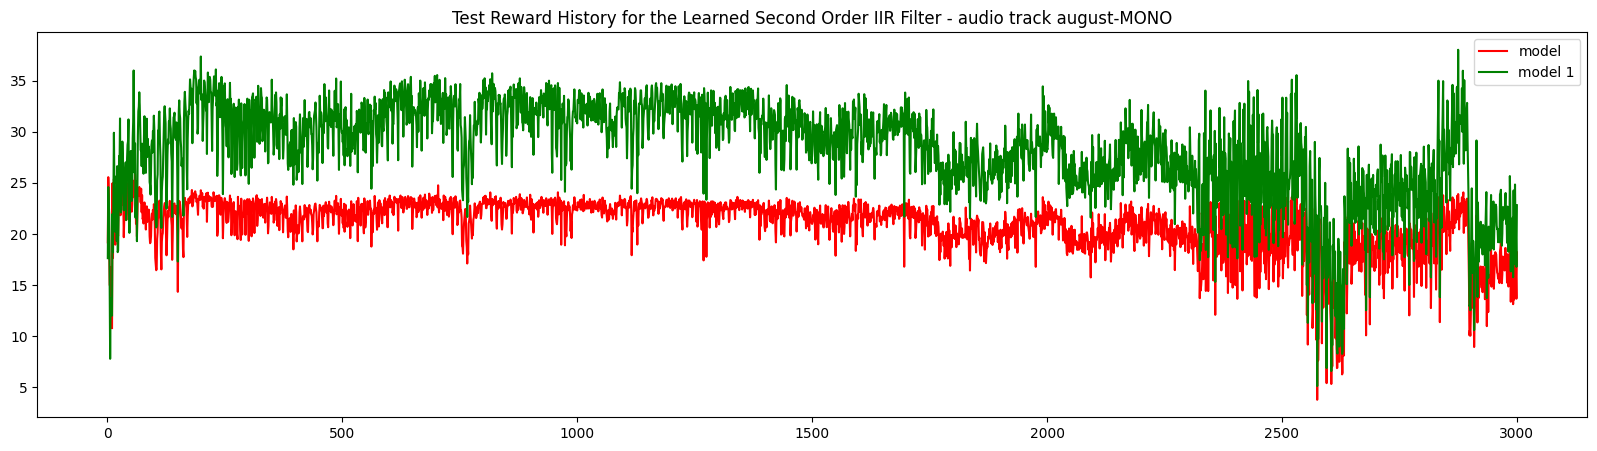

In [83]:
with open('/home/akila/FYP/coding/stage_1/audio_files/audio_files.json') as file:
    audio_names = json.load(file)['train']

# choose an audio number
audio_num = 2

# test the model
test_reward_history, test_action_history = test(model, env, audio_num, num_steps=3_000, show_effect=True)
test_reward_history_1, test_action_history_1 = test(model_1, env, audio_num, num_steps=3_000, show_effect=True)

# visulaize the rewards in testing
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(test_reward_history)+1), test_reward_history, 'r', label='model')
plt.plot(range(1, len(test_reward_history_1)+1), test_reward_history_1, 'g', label='model 1')
plt.title(f"Test Reward History for the Learned Second Order IIR Filter - audio track {audio_names[audio_num]}")
plt.legend()

In [157]:
# run the following if you want to save the current model
checkpoint_dir = 'models/try1/'
os.makedirs(checkpoint_dir, exist_ok=True)
model.save_models(checkpoint_file_name="try1", checkpoint_dir=checkpoint_dir)

..... saving models .....


### Analyzing the Results

zero: (-0.5445766002727581+0.8386875159097267j) 
pole: (0.4104741075575718+0.6951714914846178j) 
gain: 0.26851800084114075

filter: numerator: [0.268518   0.29245724 0.26850737], denominator: [ 1.         -0.82094822  0.6517524 ]


Text(0.5, 1.0, 'Pole-Zero Plot of the Learned Filter')

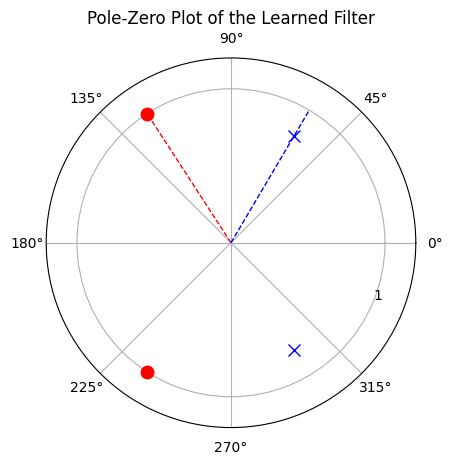

In [84]:
# let's find the average filter and visualize its pole-zero plot
average_action = np.average(np.array(test_action_history_1), axis=0)

# convert this action to an IIR filter
z = polar2cmplx(average_action[0], np.pi * average_action[1])
p = polar2cmplx(average_action[2], np.pi * average_action[3])
k = average_action[4]

print(f"zero: {z} \npole: {p} \ngain: {k}")

zs = (z, np.conjugate(z)) # array of zeros of TF
ps = (p, np.conjugate(p)) # array of poles of TF

b, a = zpk2tf(zs, ps, k)
print(f"\nfilter: numerator: {b}, denominator: {a}")

ax = plt.subplot(111, projection='polar')
for z in zs: ax.plot(np.angle(z), np.abs(z), 'o', color='r', markersize=9)
for p in ps: ax.plot(np.angle(p), np.abs(p), 'x', color='b', markersize=9)
ax.vlines(np.angle(zs[0]), ymin=0, ymax=1, color='r', linestyle='--', linewidth=1)
ax.vlines(np.angle(ps[0]), ymin=0, ymax=1, color='b', linestyle='--', linewidth=1)

ax.set_rmax(1.2)
ax.set_rticks([1])
ax.set_rlabel_position(-22.5)
ax.grid(True)
ax.set_title("Pole-Zero Plot of the Learned Filter")

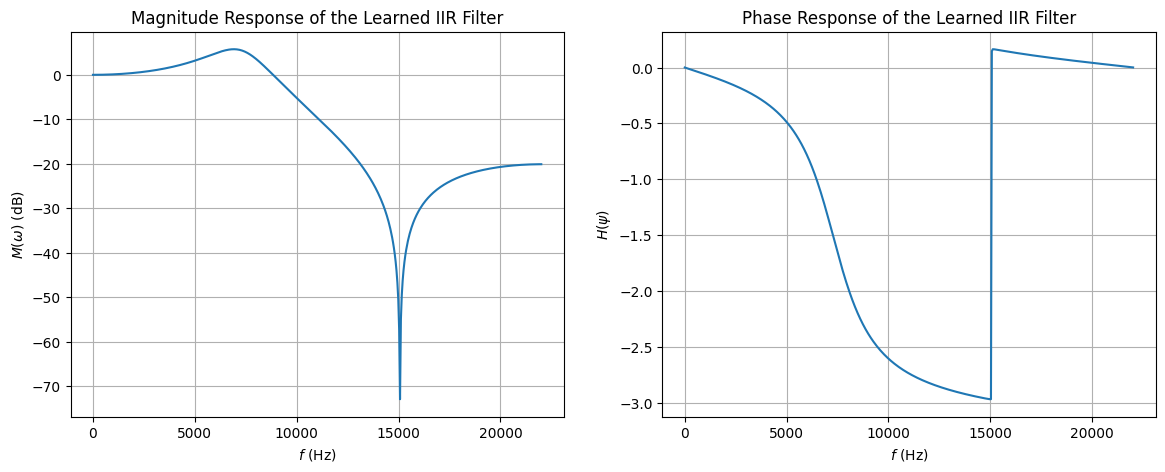

In [85]:
# let's see the frequency response of the learned IIR filter
w, h = freqz(b, a, fs=SAMPLING_FREQ)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(w, 20*np.log10(np.abs(h)))
ax[0].set_title("Magnitude Response of the Learned IIR Filter")
ax[0].set_xlabel("$f$ (Hz)")
ax[0].set_ylabel("$M(\omega)$ (dB)")
ax[0].grid(True)

ax[1].plot(w, np.angle(h))
ax[1].set_title("Phase Response of the Learned IIR Filter")
ax[1].set_xlabel("$f$ (Hz)")
ax[1].set_ylabel("$H(\psi)$")
ax[1].grid(True)

audio name: 'this_is_me_trying-MONO'
sampling rate: 44100 Hz
audio shape: (8837504,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -16760.170916024952 (>=-32768) to max: 16439.022621724518 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 23902 and upper -63625 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -48927.53244008178 (>=-2147483648) to max: 47619.789509946706 (<=2147483647)


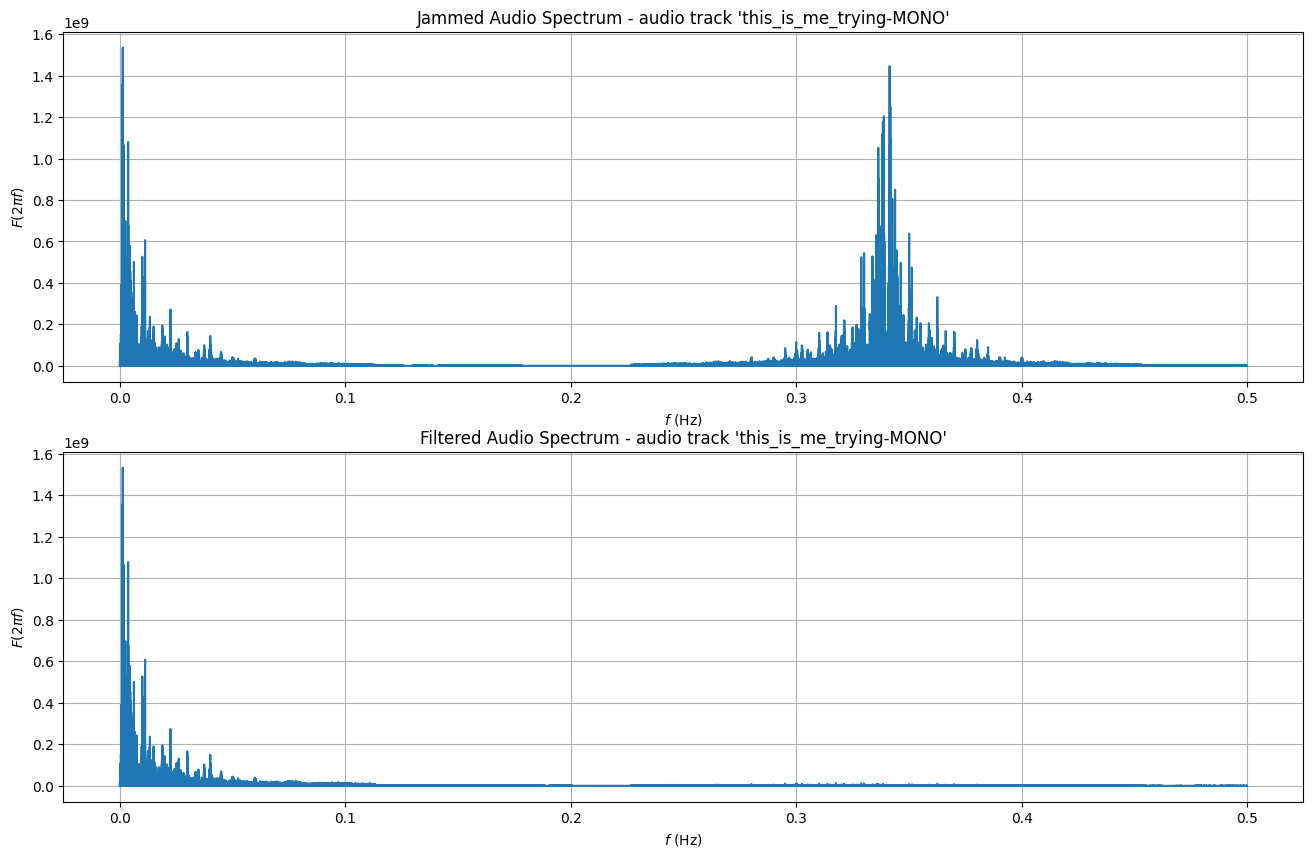

In [86]:
# let's illustrate jammed and filtered audio spectrums
audio_name = 'this_is_me_trying-MONO'
target, jammed = create_target_and_jammed_signals(audio_name, truncation_freq=TRUNCATION_FREQ, interference_center_freq=INTERFERENCE_CENTER_FREQ, signal_partition_size=S)

filtered = lfilter(b, a, jammed)
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0].plot(*Spectrum(jammed))
ax[0].set_title(f"Jammed Audio Spectrum - audio track '{audio_name}'")
ax[0].set_xlabel("$f$ (Hz)")
ax[0].set_ylabel("$F(2 \pi f)$")
ax[0].grid(True)

ax[1].plot(*Spectrum(filtered))
ax[1].set_title(f"Filtered Audio Spectrum - audio track '{audio_name}'")
ax[1].set_xlabel("$f$ (Hz)")
ax[1].set_ylabel("$F(2 \pi f)$")
ax[1].grid(True)

In [87]:
# calculate the overall SNR 
noise = filtered - target
SNR_value = 10 * np.log10(power(target)/power(noise))
print(f"overall SNR for the complete audio track {(audio_name)}: {round(SNR_value, 4)}dB")

overall SNR for the complete audio track this_is_me_trying-MONO: 23.292dB


### *Can We have a better IIR Filter?*


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'rain_on_me-MONO'
sampling rate: 44100 Hz
audio shape: (8305664,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -18879.494656565814 (>=-32768) to max: 17182.003427808108 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 23603 and upper -250474 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49095.53950461225 (>=-2147483648) to max: 49100.5372207998 (<=2147483647)



/home/akila/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'arms_around_you-MONO'
sampling rate: 44100 Hz
audio shape: (8631296,)
data type: int16
MONO audio file...
generating the target signal...
	truncating the spectrum at 5000Hz
	converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
	trimming the audio signal...
		truncating the audio at lower 47706 and upper -33914 indices
generating the jammed signal...
	creating a non-overlapping interference signal around 15000Hz with a bandwidth of 10000Hz
	converting from float64 to <class 'numpy.int32'>; array ranges from min: -49140.51895186492 (>=-2147483648) to max: 49149.0 (<=2147483647)


--------------------------------------------------episode no: 1--------------------------------------------------
audio name: 'rain_on_me-MONO'
sampling rate: 44100 Hz
audio shape: (8305664,)
data ty

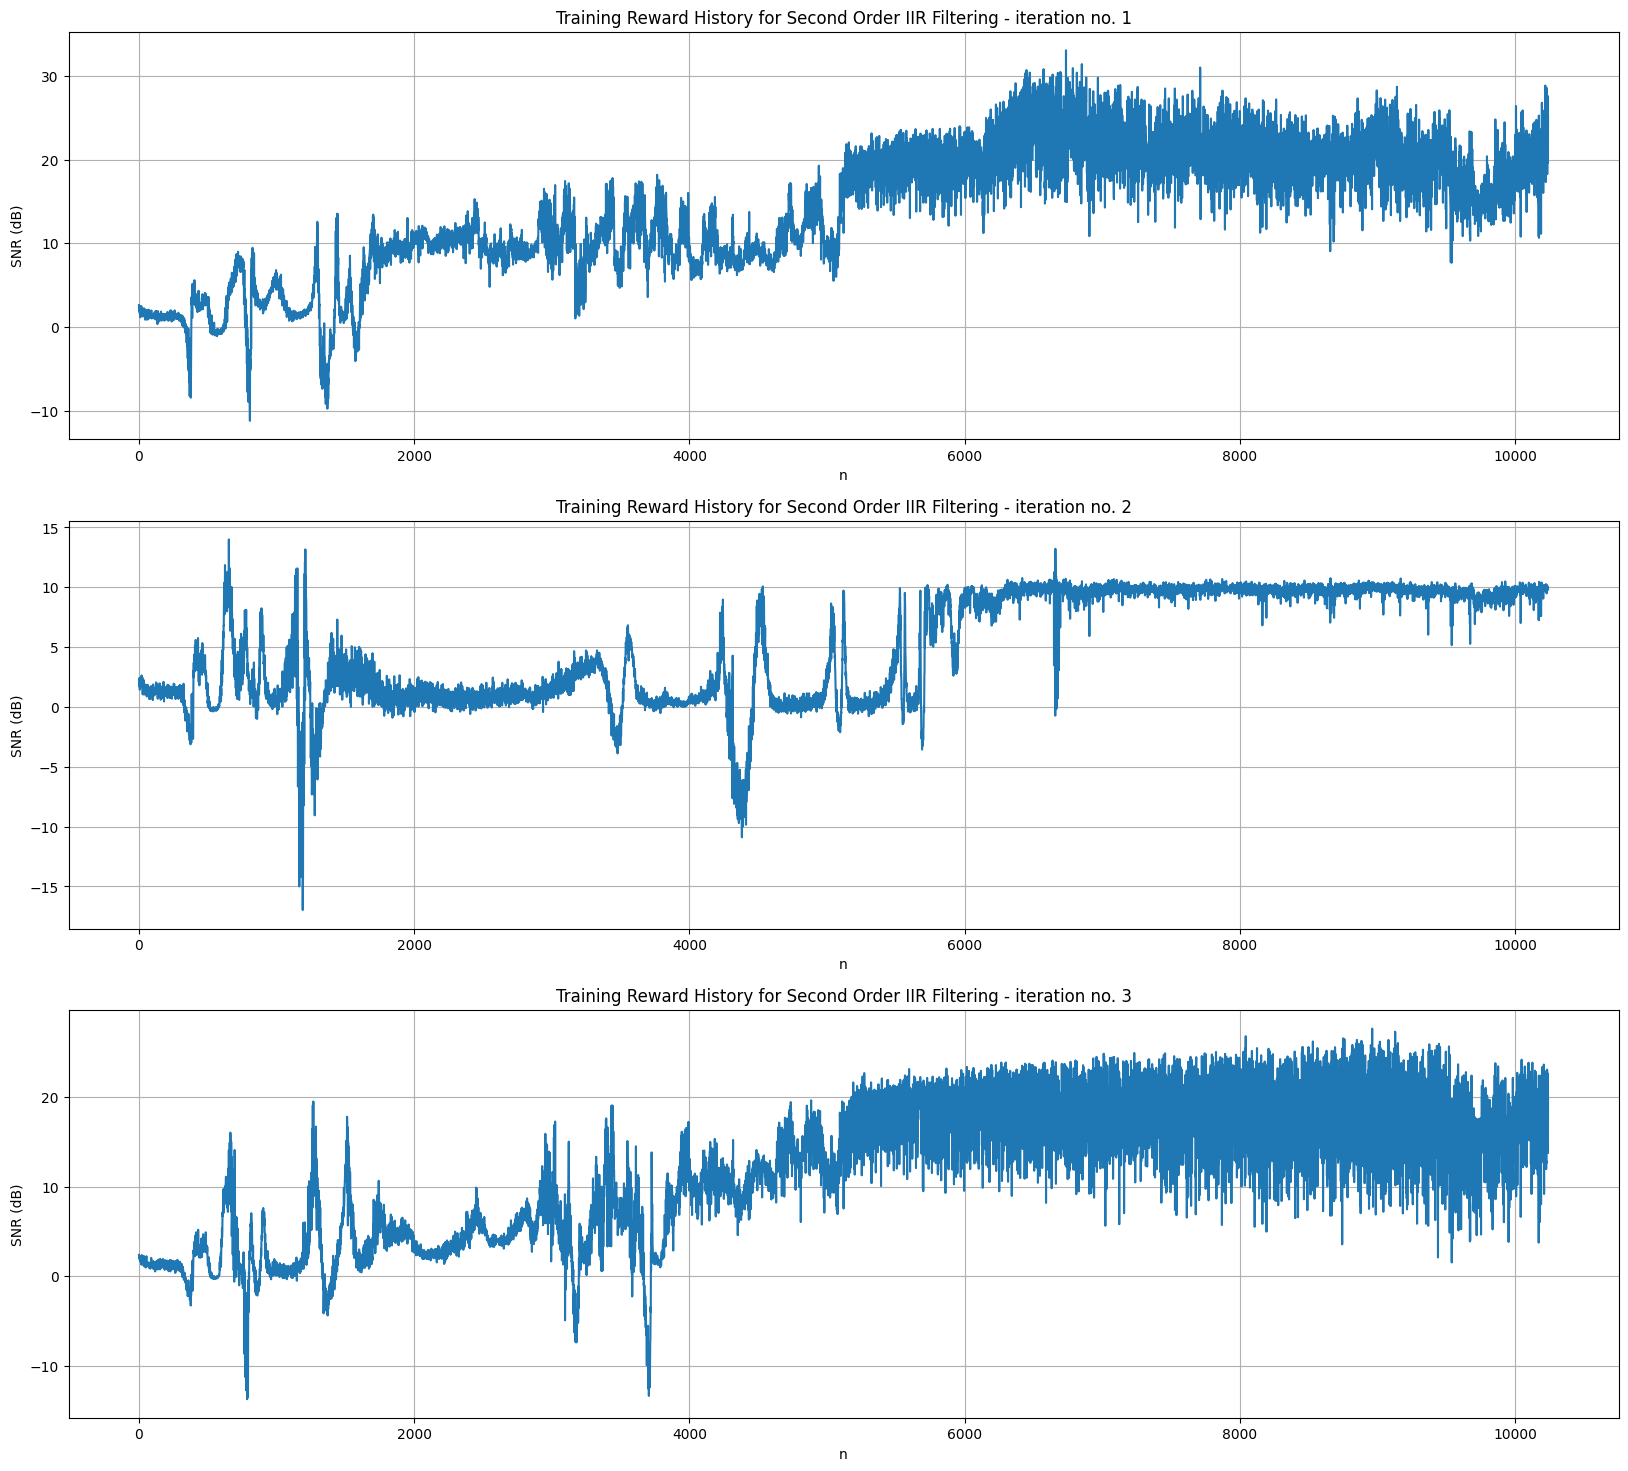

In [93]:
# declare a new environment instance
env_ = ReceiverEnvWithSecondOrderIIR(S, cut_off_freq=TRUNCATION_FREQ, interference_center_freq=INTERFERENCE_CENTER_FREQ)

# run the training for few iterations
step_num = 3
fig, ax = plt.subplots(nrows=step_num, ncols=1, figsize=(20, 6*step_num))

for i in range(step_num):

    # launch a new DDPG agent
    keras.backend.clear_session()
    model_2 = DDPGAgent(
        input_dims  = env_.observation_space.shape,
        n_actions   = env_.action_space.shape[0],
        alpha       = 0.0001, # learning rate of actor
        beta        = 0.001,  # learning rate of critic
        gamma       = 0.1,
        tau         = 0.001,
        critic_fc1  = 512,
        critic_fc2  = 256, #...
        actor_fc1   = 256,
        actor_fc2   = 128,
        batch_size  = 128*2,
        buffer_size = 128*2, # buffer size is reduced to the batch size
        noise       = 0.01
    )

    # train the model
    train_time_steps = 128*40
    reward_history_2, action_history_2 = train(model_2, env_, audio_num=4, max_num_steps=train_time_steps, show_effect=False)
    reward_history_2, action_history_2 = train(model_2, env_, audio_num=1, max_num_steps=train_time_steps, show_effect=False, reward_history=reward_history_2, action_history=action_history_2)

    ax[i].plot(range(1, len(reward_history_2)+1), reward_history_2)
    ax[i].set_title(f"Training Reward History for Second Order IIR Filtering - iteration no. {i+1}")
    ax[i].set_xlabel("n")
    ax[i].set_ylabel("SNR (dB)")
    ax[i].grid(True)